# **Environments and Functions**

It will take a few minutes for:

1. Download codes and pre-trained weights
2. Install Packages
3. Define common functions
4. Init the model

(Try to use gpu to speed up inference.)

In [4]:
!pip install gdown
import gdown
url='https://drive.google.com/u/0/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe'
file_name='ViTMatte_S_Com.pth'
gdown.download(url, file_name)

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe
From (redirected): https://drive.google.com/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe&confirm=t&uuid=664dd35a-f3b4-40b8-82eb-182f77ff71a5
To: /Users/danielhauschildt/Developer/@IMGLY-labs/ViTMatte/ViTMatte_S_Com.pth
100%|██████████| 103M/103M [00:13<00:00, 7.58MB/s] 


'ViTMatte_S_Com.pth'

In [5]:
# install packages

!pip install fairscale timm
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /private/var/folders/rw/8r6b2bj91z33d1kfw14sj4gw0000gn/T/pip-req-build-zgvx026d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/rw/8r6b2bj91z33d1kfw14sj4gw0000gn/T/pip-req-build-zgvx026d
  Resolved https://github.com/facebookresearch/detectron2.git to commit 67ac149947124670f6678e1bdd75f89dbf0dd5e7
  Preparing metadata (setup.py) ... done


In [6]:
# common functions
# os.chdir('/content/ViTMatte')
import os
from PIL import Image
from os.path import join as opj
from torchvision.transforms import functional as F
from detectron2.engine import default_argument_parser
from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer

def infer_one_image(model, input, save_dir=None):
    """
    Infer the alpha matte of one image.
    Input:
        model: the trained model
        image: the input image
        trimap: the input trimap
    """

    image, trimap, _, H, W = model.preprocess_inputs(input)
     
    output = model(image, trimap)['phas']
    output = output[:,:,:H,:W].flatten(0, 2)
    output = F.to_pil_image(output)
    output.save(opj(save_dir))

    return None

def init_model(model, checkpoint, device):
    """
    Initialize the model.
    Input:
        config: the config file of the model
        checkpoint: the checkpoint of the model
    """
    assert model in ['vitmatte-s', 'vitmatte-b']
    if model == 'vitmatte-s':
        config = 'configs/common/model.py'
        cfg = LazyConfig.load(config)
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    elif model == 'vitmatte-b':
        config = 'configs/common/model.py'
        cfg = LazyConfig.load(config)
        cfg.model.backbone.embed_dim = 768
        cfg.model.backbone.num_heads = 12
        cfg.model.decoder.in_chans = 768
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    return model

def get_data(image_dir, trimap_dir):
    """
    Get the data of one image.
    Input:
        image_dir: the directory of the image
        trimap_dir: the directory of the trimap
    """
    image = Image.open(image_dir).convert('RGB')
    image = F.to_tensor(image).unsqueeze(0)
    trimap = Image.open(trimap_dir).convert('L')
    trimap = F.to_tensor(trimap).unsqueeze(0)

    return {
        'image': image,
        'trimap': trimap
    }

def cal_foreground(image_dir, alpha_dir):
    """
    Calculate the foreground of the image.
    Input:
        image_dir: the directory of the image
        alpha_dir: the directory of the alpha matte
    Output:
        foreground: the foreground of the image, numpy array
    """
    image = Image.open(image_dir).convert('RGB')
    alpha = Image.open(alpha_dir).convert('L')
    alpha = F.to_tensor(alpha).unsqueeze(0)
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground

def merge_new_bg(image_dir, bg_dir, alpha_dir):
    """
    Merge the alpha matte with a new background.
    Input:
        image_dir: the directory of the image
        bg_dir: the directory of the new background
        alpha_dir: the directory of the alpha matte
    """
    image = Image.open(image_dir).convert('RGB')
    bg = Image.open(bg_dir).convert('RGB')
    alpha = Image.open(alpha_dir).convert('L')
    image = F.to_tensor(image)
    bg = F.to_tensor(bg)
    bg = F.resize(bg, image.shape[-2:])
    alpha = F.to_tensor(alpha)
    new_image = image * alpha + bg * (1 - alpha)

    new_image = new_image.squeeze(0).permute(1, 2, 0).numpy()
    return new_image

In [7]:
# init the model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = init_model(model='vitmatte-s', checkpoint='./ViTMatte_S_Com.pth', device=device)

/Users/danielhauschildt/Developer/@IMGLY-labs/.conda/lib/python3.10/site-packages/detectron2/config/lazy.py:167: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return old_import(name, globals, locals, fromlist=fromlist, level=level)


# **Results on Composition-1k**
1. Opaque Object
2. Transparent Object

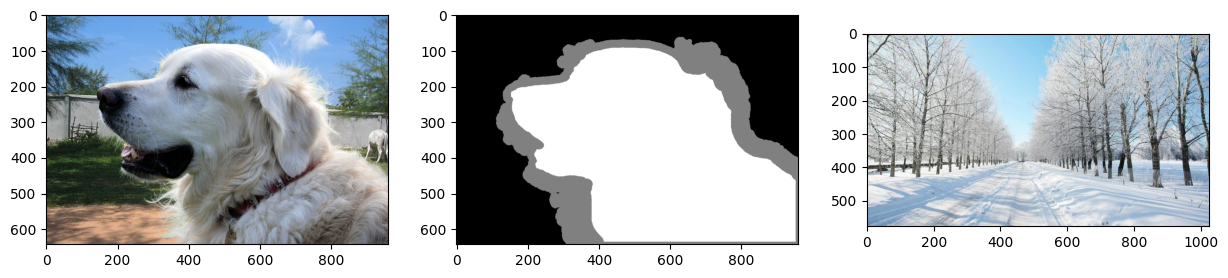

In [8]:
# get opaque data
import matplotlib.pyplot as plt
import numpy as np

image_dir = './demo/retriever_rgb.png'
trimap_dir = './demo/retriever_trimap.png'
bg_dir = './demo/new_bg.jpg'

image = np.array(Image.open(image_dir))
trimap = np.array(Image.open(trimap_dir))
bg = np.array(Image.open(bg_dir))

input = get_data(image_dir, trimap_dir)
#print(input)
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(trimap)
plt.subplot(1, 3, 3)
plt.imshow(bg)
plt.show()

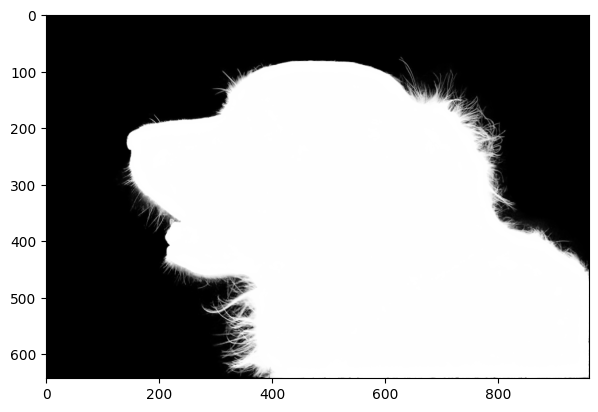

In [9]:
# infer with model
save_dir = './demo/result.png'
alpha = infer_one_image(model, input, save_dir)

plt.figure(figsize=(7, 7))
plt.imshow(np.array(Image.open('demo/result.png')), cmap='gray')
plt.show()

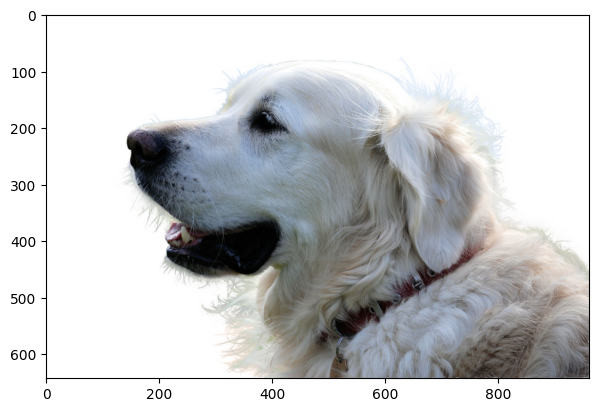

In [10]:
# calculate foreground with the alpha matte prediction

fg = cal_foreground(image_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

/Users/danielhauschildt/Developer/@IMGLY-labs/.conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


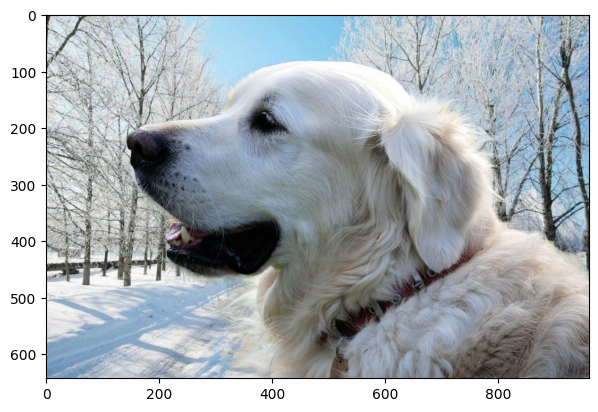

In [11]:
# merge with new background

new_image = merge_new_bg(image_dir, bg_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()

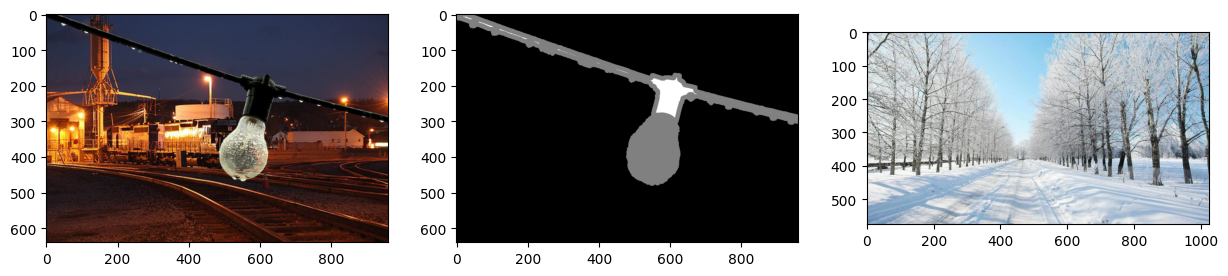

In [12]:
# get transparent data

image_dir = './demo/bulb_rgb.png'
trimap_dir = './demo/bulb_trimap.png'

image = np.array(Image.open(image_dir))
trimap = np.array(Image.open(trimap_dir))
bg = np.array(Image.open(bg_dir))

input = get_data(image_dir, trimap_dir)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(trimap)
plt.subplot(1, 3, 3)
plt.imshow(bg)
plt.show()

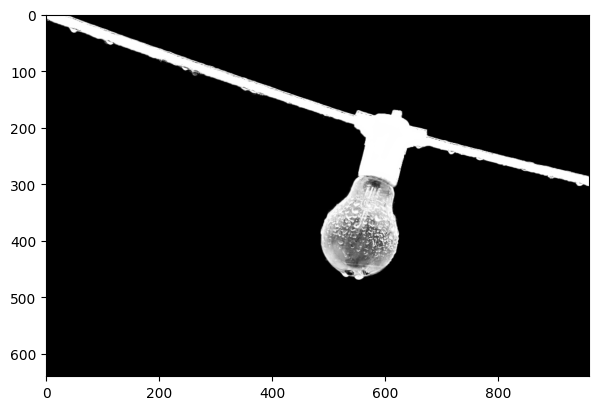

In [13]:
# infer with model
save_dir = './demo/result.png'
alpha = infer_one_image(model, input, save_dir)

plt.figure(figsize=(7, 7))
plt.imshow(np.array(Image.open('demo/result.png')), cmap='gray')
plt.show()

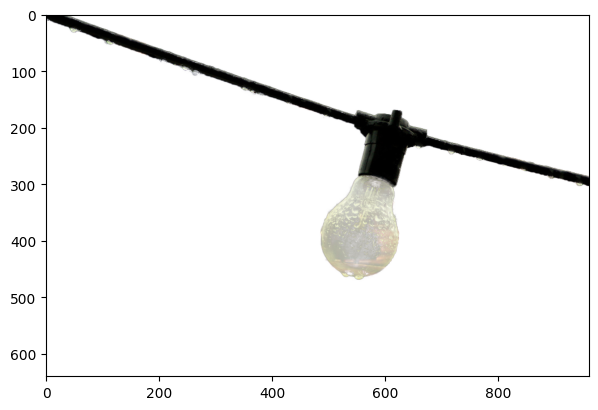

In [14]:
# calculate foreground with the alpha matte prediction

fg = cal_foreground(image_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

/Users/danielhauschildt/Developer/@IMGLY-labs/.conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


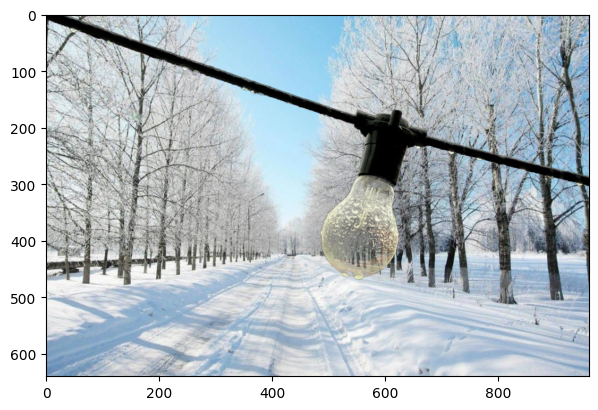

In [15]:
# merge with new background

new_image = merge_new_bg(image_dir, bg_dir, save_dir)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()

# ONNX Conversion



In [17]:
!pip install onnx onnxconverter-common onnxruntime

In [4]:

import onnx
from onnxconverter_common import float16
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import matplotlib.pyplot as plt

def exportModelToOnnx(model, name= "ViTMatte", opset=15, resolution=1024):
  doSimplify = True

  image = torch.randn(1, 3, resolution, resolution).type(torch.FloatTensor)
  matte = torch.randn(1, 1, resolution, resolution).type(torch.FloatTensor)

  input_names = ["image", "trimap"]
  output_names = ["alpha"]

  name = "ViTMatte"

  base_file_name= './{name}-op{opset}-{resolution}.onnx'.format(opset=opset, resolution=resolution, name=name)
  ## full network
  torch.onnx.export(model,
                  (image, matte),
                  base_file_name,
                  verbose=False,
                  opset_version=opset,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

  onnx_model = onnx.load(base_file_name)

  # simplify model
  if doSimplify:
    from onnxsim import simplify
    onnx_model, check = simplify(onnx_model)
    onnx.save(onnx_model, base_file_name)
    
  ## convert to fp16
  fp16_file_name= './{name}-op{opset}-{resolution}-fp16.onnx'.format(opset=opset, resolution=resolution, name=name)
  onnx_model_fp16 = float16.convert_float_to_float16(onnx_model, keep_io_types=True)

  onnx.save(onnx_model_fp16, fp16_file_name)

  ## convert to Quant8
  quint8_file_name= './{name}-op{opset}-{resolution}-quint8.onnx'.format(opset=opset, resolution=resolution, name=name)
  quantize_dynamic(base_file_name, quint8_file_name, weight_type=QuantType.QUInt8)

exportModelToOnnx(model, "VitMatte")


NameError: name 'model' is not defined

# ONNX Testing

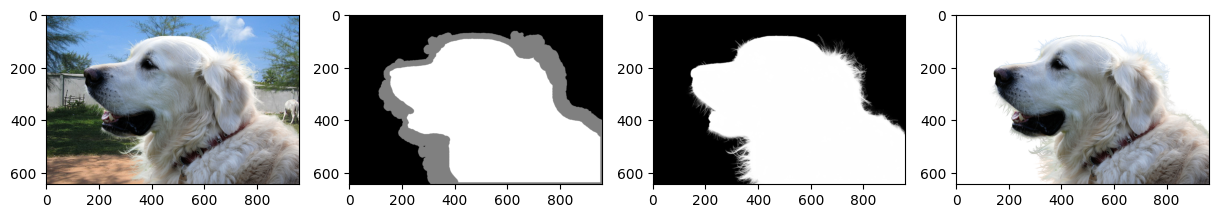

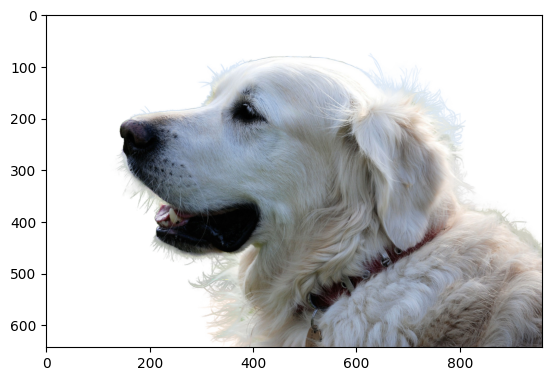

In [5]:

# Do Resize only if images are larger than 1024x1024
# Do proportional resize
# Do padding to get to 1024x1024

!pip install onnxruntime onnxsim
import onnxruntime as ort
import numpy as np
import torch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt


## Is padding or resizing better?
def preprocess(image, trimap):
  pixel_mean = torch.tensor([123.675 / 255., 116.280 / 255., 103.530 / 255.]).view(-1, 1, 1)
  pixel_std = torch.tensor([58.395 / 255., 57.120 / 255., 57.375 / 255.]).view(-1, 1, 1)
  image_tensor = F.to_tensor(image).unsqueeze(0)
  trimap_tensor = F.to_tensor(trimap).unsqueeze(0)
  image_tensor = (image_tensor - pixel_mean) / pixel_std
  return image_tensor.numpy(), trimap_tensor.numpy()

def pad(ort_image, ort_trimap):
  # Pad ort_image to 1024x1024 
  ort_image = np.pad(ort_image, ((0, 0), (0, 0), (0, 1024 - ort_image.shape[-2]), (0, 1024 - ort_image.shape[-1])), mode='constant', constant_values=0)
  # Pad ort_trimap to 1024x1024
  ort_trimap = np.pad(ort_trimap, ((0, 0), (0, 0), (0, 1024 - ort_trimap.shape[-2]), (0, 1024 - ort_trimap.shape[-1])), mode='constant', constant_values=0)
  return ort_image, ort_trimap

def inference(image, trimap):

  ## Here we go

  modelFile = "ViTMatte-op15-1024.onnx"
  # modelFile = "ViTMatte-op15-1024-fp16.onnx"
  # modelFile = "ViTMatte+op15+fp16.onnx"
  # modelFile = "ViTMatte+op15+QUInt8.onnx"
  resolution = 1024

  doResize = True
  doPadding = False

  
  src_width = image.width
  src_height = image.height


  # Resize to 1024x1024
  if doResize:
    image = image.resize([resolution, resolution], PIL.Image.LANCZOS)
    trimap = trimap.resize([resolution, resolution], PIL.Image.LANCZOS)


  ort_image, ort_trimap = preprocess(image, trimap)

  if doPadding:
    ort_image, ort_trimap = pad(ort_image, ort_trimap,)


  ort_sess = ort.InferenceSession(modelFile)
  ort_inputs = {'image': ort_image, 'trimap': ort_trimap}
  ort_outputs = ort_sess.run(None, ort_inputs)
  output = ort_outputs[0]
  # combined = (output*ort_image) + (1-output)
  output = output.squeeze()

  alpha = PIL.Image.fromarray((output * 255).astype(np.uint8))
  if doPadding:
    # todo
    pass

  
  if doResize:
    alpha = alpha.resize([src_width, src_height], PIL.Image.LANCZOS)

  return alpha


# use Glas Demo
# image_dir = './demo/bulb_rgb.png'
# trimap_dir = './demo/bulb_trimap.png'
image_dir = './demo/retriever_rgb.png'
trimap_dir = './demo/retriever_trimap.png'
bg_dir = './demo/new_bg.jpg'

image = Image.open(image_dir).convert('RGB')
trimap = Image.open(trimap_dir).convert('L')

alpha = inference(image, trimap)

src_w = image.width
src_h = image.height


image = Image.open(image_dir).convert('RGB')
trimap = Image.open(trimap_dir).convert('L')

plt.figure(figsize=(15, 7))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.subplot(1, 4, 2)
plt.imshow(trimap, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(alpha, cmap='gray')
plt.subplot(1, 4, 4)
image.putalpha(alpha)
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(image)
plt.show()

In [ ]:
onnx.load()